In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential


column_names = ["Date", "OilPrice"]
# Fetch Brent oil prices using yfinance
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd',names=column_names)

# Display the first few rows of the data
print(brent_data.head())


        Date  OilPrice
0 1987-05-22     18.55
1 1987-05-25     18.60
2 1987-05-26     18.63
3 1987-05-27     18.60
4 1987-05-28     18.60


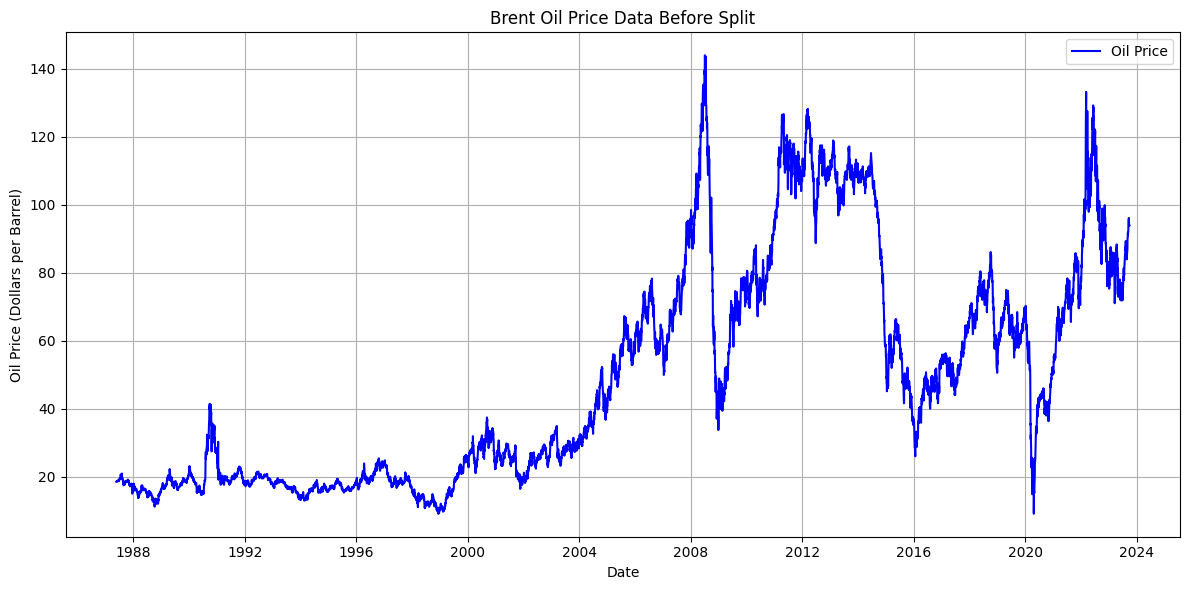

In [ ]:
# Extract the 'OilPrice' column as your target variable
oil_prices = brent_data['OilPrice']

# Extract the dates for plotting
dates = brent_data['Date']

# Create a figure and plot the entire data
plt.figure(figsize=(12, 6))
plt.plot(dates, oil_prices, label='Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Data Before Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Normalize the data using Min-Max scaling
oil_prices = brent_data['OilPrice'].values.reshape(-1, 1)
scaler = MinMaxScaler()
normalized_oil_prices = scaler.fit_transform(oil_prices)


In [ ]:
# Find the index corresponding to the date "2010-01-01"
split_date = pd.to_datetime("2010-01-01")

# Find the nearest date in the DataFrame to the target split date
nearest_date = brent_data.loc[brent_data['Date'] >= split_date, 'Date'].min()

# Find the index corresponding to the nearest date
split_index = brent_data[brent_data['Date'] == nearest_date].index[0]

# Split the data into training and testing sets
train_data = normalized_oil_prices[:split_index]
test_data = normalized_oil_prices[split_index:]



In [ ]:
print(nearest_date)
print(test_data[0])

2010-01-04 00:00:00
[0.51872451]


In [ ]:

# Print the shapes of the training and testing sets to verify the split
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (5749, 1)
Testing data shape: (3474, 1)


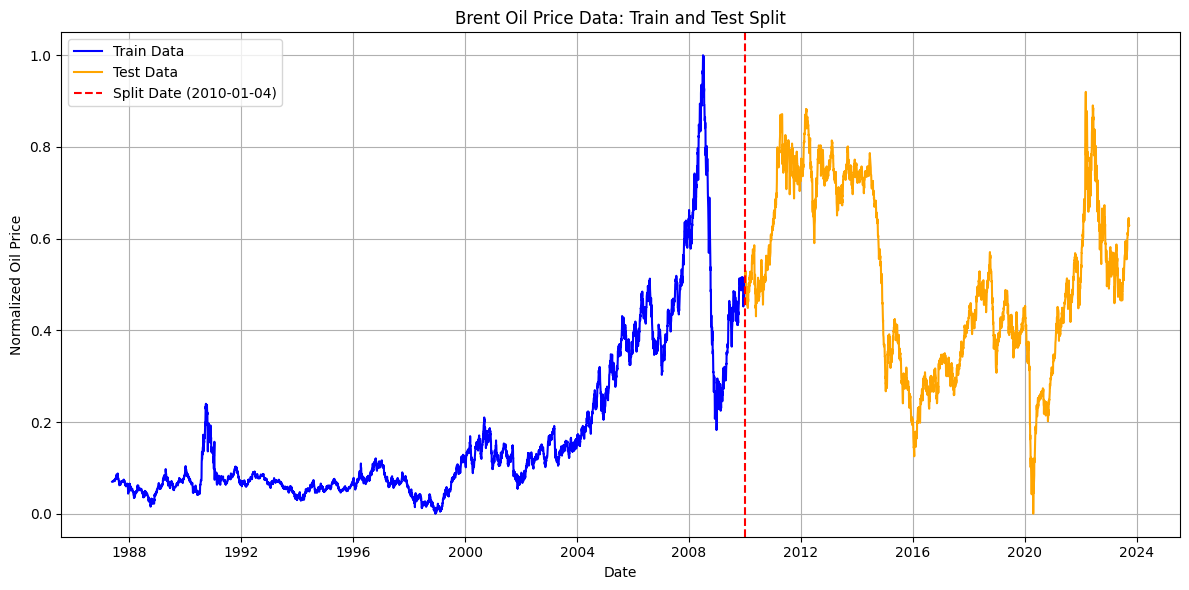

In [ ]:
# Create a figure and plot the data
plt.figure(figsize=(12, 6))

# Plot the training data in blue
plt.plot(brent_data['Date'][:split_index], train_data, label='Train Data', color='blue')

# Plot the testing data in orange
plt.plot(brent_data['Date'][split_index:], test_data, label='Test Data', color='orange')

# Add a vertical dashed line at the split date
plt.axvline(x=nearest_date, color='red', linestyle='--', label='Split Date (2010-01-04)')

plt.xlabel('Date')
plt.ylabel('Normalized Oil Price')
plt.title('Brent Oil Price Data: Train and Test Split')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Prepare the data for the LSTM model

# Define a function to create sequences from the data
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length (number of time steps to look back)
sequence_length = 10

In [ ]:
# Create sequences for training and testing data
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)


In [ ]:
# Reshape the data to match the input shape of the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Step 2: Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Step 3: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Step 4: Fit the model to the training data
model.fit(X_train, y_train, epochs=25, batch_size=32)

# Step 5: Evaluate the model on the test data
train_loss = model.evaluate(X_train, y_train, verbose=0)
# test_loss = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/25
180/180 [==============================] - 5s 8ms/step - loss: 0.0035
Epoch 2/25
180/180 [==============================] - 1s 8ms/step - loss: 2.2015e-04
Epoch 3/25
180/180 [==============================] - 1s 7ms/step - loss: 2.1045e-04
Epoch 4/25
180/180 [==============================] - 1s 7ms/step - loss: 1.9767e-04
Epoch 5/25
180/180 [==============================] - 1s 8ms/step - loss: 1.8373e-04
Epoch 6/25
180/180 [==============================] - 1s 8ms/step - loss: 1.8164e-04
Epoch 7/25
180/180 [==============================] - 2s 12ms/step - loss: 1.6832e-04
Epoch 8/25
180/180 [==============================] - 1s 8ms/step - loss: 1.5166e-04
Epoch 9/25
180/180 [==============================] - 1s 8ms/step - loss: 1.5171e-04
Epoch 10/25
180/180 [==============================] - 1s 8ms/step - loss: 1.3761e-04
Epoch 11/25
180/180 [==============================] - 1s 7ms/step - loss: 1.4697e-04
Epoch 12/25
180/180 [==============================] - 1s 7ms/step

In [ ]:
print(f'Training Loss: {train_loss}')
# print(f'Test Loss: {test_loss}')

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)


In [ ]:
# Create a DataFrame to compare the predictions with the actual values
test_dates = brent_data['Date'][split_index+sequence_length:].reset_index(drop=True)
comparison_df = pd.DataFrame({'Date': test_dates, 'Actual': y_test_original.flatten(), 'Predicted': y_pred_original.flatten()})
comparison_df.head()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
# Calculate RMSE (Root Mean Squared Error) on the test data
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculate the percentage accuracy
percentage_accuracy = 100 * (1 - (rmse / np.mean(y_test_original)))

# Print the RMSE and percentage accuracy
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Percentage Accuracy: {percentage_accuracy:.2f}%")



In [ ]:
# Plot the actual vs. predicted oil prices
plt.figure(figsize=(12, 6))
plt.plot(dates[split_index+sequence_length:], comparison_df['Actual'], label='Actual', color='blue')
plt.plot(dates[split_index+sequence_length:], comparison_df['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price: Actual vs. Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import datetime

In [ ]:
pred_date_value = pd.to_datetime("2023-02-16")
# Find the row where 'Date' matches 'pred_date_value'
matching_row = comparison_df[comparison_df['Date'] == pred_date_value]

# Print the matching row
print(matching_row)
